# Symbolic Regression Implementation

In [14]:
import numpy as np
from icecream import ic

data = np.load('../data/problem_7.npz')  
x_validation = data['x'] 
y_validation = data['y']

num_vars = x_validation.shape[0]
VARIABLES = [f"x{i}" for i in range(num_vars)]


## Tree Node Definition

In [15]:
import math
import operator
import random

class Node:
    def __init__(self, value, children=None):
        """
        value could be:
            - a float (constant);
            - a string (a variable name like 'x0','x1', ...):
            - a Python function ( math.sin, operator.add, ...)
        """
        self.value = value
        self.children = children if children is not None else []
    
    def is_leaf(self):
        return len(self.children) == 0

## Tree Creation

In [16]:
def evaluate(node: Node, x: np.ndarray) -> np.ndarray:
    if node.is_leaf():
        val = node.value
        # Case 1: constant
        if isinstance(val, (float, int)) and not isinstance(val, bool):
            return np.full(x.shape[1], float(val))
        
        # Case 2: variable
        if isinstance(val, str) and val.startswith("x"):
            try:
                idx = VARIABLES.index(val)
            except ValueError:
                raise ValueError(f"Unknown Variable: {val}")
            return x[idx, :]  
    
        # Fallback
        raise ValueError(f"Unknown leaf value: {val}")

    else:
        # Case 3: internal node
        op = node.value
        children_values = [evaluate(child, x) for child in node.children]

        if len(children_values) == 1:
            return safe_apply_unary(op, children_values[0])
        elif len(children_values) == 2:
            return safe_apply_binary(op, children_values[0], children_values[1])
        else:
            raise ValueError("Children number not supported")


        
def protected_div(a, b):
    if abs(b) < 1e-12:
        return 1.0
    return a / b

def protected_sqrt(x):
    if x < 0:
        return math.sqrt(abs(x))
    return math.sqrt(x)

def protected_log10(x):
    if x <= 0:
        return 0.0
    return math.log10(x)

def safe_apply_unary(func, arr):
    vfunc = np.frompyfunc(func, 1, 1)
    return vfunc(arr).astype(float)

def protected_exp(x):
    # Overflow condition
    if x > 700:
        return math.exp(700)  
    # Underflow condition
    elif x < -700:
        return math.exp(-700)
    else:
        return math.exp(x)
def safe_apply_binary(func, arr1, arr2):
    vfunc = np.frompyfunc(func, 2, 1)
    return vfunc(arr1, arr2).astype(float)


DEPTH_MAX = 4
CONST_MAX = 10
CONST_MIN = -10

UNARY_FUNCS = [
    math.sin,
    math.cos,
    operator.neg,
    abs,
    protected_log10,
    protected_sqrt,
    protected_exp
]

BINARY_FUNCS = [
    operator.add,
    operator.sub,
    operator.mul,
    protected_div
]

def generate_subtree_forced_var(
    var: str,  
    depth: int,
    constant_min=CONST_MIN,
    constant_max=CONST_MAX
) -> Node:
    """
    Generate recursively a subtree with a variable var at the root.
    """
    if depth <= 0:
        return Node(var)
    else:
        if random.random() < 0.3:
            op = random.choice(UNARY_FUNCS)
            child = generate_subtree_forced_var(var, depth - 1, constant_min, constant_max)
            return Node(op, [child])
        else:
            op = random.choice(BINARY_FUNCS)
            left = generate_subtree_forced_var(var, depth - 1, constant_min, constant_max)
            right = generate_random_subtree(depth - 1, constant_min=constant_min, constant_max=constant_max)
            return Node(op, [left, right])


        
def generate_random_subtree(depth, constant_min=CONST_MIN, constant_max=CONST_MAX) -> Node:
    """
    Generate a random subtree without any constraint on the variables.
    """
    variables = VARIABLES.copy()

    if depth <= 0 or (depth > 1 and random.random() < 0.3):
        if random.random() < 0.5 and variables:
            # Choosing a random variable from the subset
            var = random.choice(variables)
            return Node(var)
        else:
            #Choosing a random constant
            return Node(random.uniform(constant_min, constant_max))
    else:
        if random.random() < 0.3 and UNARY_FUNCS:
            op = random.choice(UNARY_FUNCS)
            child = generate_random_subtree(depth - 1, constant_min=constant_min, constant_max=constant_max)
            return Node(op, [child])
        else:
            op = random.choice(BINARY_FUNCS)
            left = generate_random_subtree(depth - 1, constant_min=constant_min, constant_max=constant_max)
            right = generate_random_subtree(depth - 1, constant_min=constant_min, constant_max=constant_max)
            return Node(op, [left, right])

def generate_random_tree(depth=DEPTH_MAX, constant_min=CONST_MIN, constant_max=CONST_MAX) -> Node:
    """
    Generate a tree which includes all the variables.
    """
    if len(VARIABLES) == 0:
        raise ValueError("There is no variable available.")
    elif len(VARIABLES) == 1:
        var = VARIABLES[0]
        return generate_subtree_forced_var(var, depth, constant_min=constant_min, constant_max=constant_max)
    else:
        if random.random() < 0.3 and UNARY_FUNCS:
            # Unary operator
            op = random.choice(UNARY_FUNCS)
            child = generate_random_subtree(depth - 1, constant_min=constant_min, constant_max=constant_max)
            return Node(op, [child])
        elif BINARY_FUNCS:
            # Binary operator
            op = random.choice(BINARY_FUNCS)
            left_subtree = generate_random_subtree(depth - 1, constant_min=constant_min, constant_max=constant_max)
            right_subtree = generate_random_subtree(depth - 1, constant_min=constant_min, constant_max=constant_max)
            return Node(op, [left_subtree, right_subtree])
        else:
            # Fallback: generate a random subtree without constraints
            return generate_random_subtree(depth, constant_min=constant_min, constant_max=constant_max)
        

## Expression String

In [17]:
DISPLAY_NAME_MAP = {
    operator.add: '+',
    operator.sub: '-',
    operator.mul: '*',
    protected_div: '/',
    math.sin: 'sin',
    math.cos: 'cos',
    operator.neg: '-',
    abs: 'abs',
    protected_log10: 'log10',
    protected_sqrt: 'sqrt',
    protected_exp: 'exp',
}

def tree_to_string(node: Node) -> str:
    """ It Returns a string representation of the tree node """
    # Case 1: Leaf node
    if node.is_leaf():
        val = node.value
        # Constant
        if isinstance(val, (float, int)) and not isinstance(val, bool):
            return f"{float(val):.3f}"
        # Variable
        if isinstance(val, str) and val.startswith("x"):
            idx = val[1]  
            return f"x{idx}"
        # fallback
        return str(val)

    # Caso 2: Internal node (Operator)
    else:
        op = node.value
        child_strs = [tree_to_string(child) for child in node.children]
        op_name = DISPLAY_NAME_MAP.get(op, op.__name__ if hasattr(op, '__name__') else str(op))
        # Unary operator
        if len(child_strs) == 1:
            return f"{op_name}({child_strs[0]})"

        # Binary operator
        elif len(child_strs) == 2:
            left_str, right_str = child_strs
            return f"({left_str} {op_name} {right_str})"
        else:
            raise ValueError("Children number not supported")

## Conversion Function
They are useful to convert the tree generated my algorithm into the format the draw function in gxgp directory needs.

In [18]:
from gxgp.node import Node as GXNode
from gxgp.draw import draw

def make_var_func(var_name):
    """It creates a function that returns the value of a variable from the keyword arguments."""
    def var_func(**kwargs):
        return kwargs[var_name]
    var_func.__name__ = var_name
    return var_func

def make_const_func(const_val):
    """It creates a function that returns a constant value."""
    def const_func(**kwargs):
        return const_val
    const_func.__name__ = f"{const_val:.3f}"
    return const_func

def convert_to_gxgp_node(my_node, subtree=None) -> GXNode:
    """
    It converts a Node object to a GXNode object.
    """
    if subtree is None:
        subtree = set()

    if my_node.is_leaf():
        val = my_node.value
        if isinstance(val, str):
            
            var_name = val
            var_func = make_var_func(var_name)
            display_name = DISPLAY_NAME_MAP.get(var_name, var_name)
            gx_node = GXNode(var_func, [], name=display_name)      
        else:
            const_val = float(val)
            const_func = make_const_func(const_val)
            display_name = f"{const_val:.3f}"  
            gx_node = GXNode(const_func, [], name=display_name) 
        subtree.add(gx_node)
        return gx_node
    else:
        op = my_node.value
        gx_op = op  
        display_name = DISPLAY_NAME_MAP.get(op, op.__name__ if hasattr(op, '__name__') else str(op))
        converted_children = []
        for child in my_node.children if my_node.children is not None else []:
            converted_child = convert_to_gxgp_node(child, subtree)
            converted_children.append(converted_child)

        gx_node = GXNode(gx_op, converted_children, name=display_name)
        subtree.add(gx_node)
        return gx_node


## Fitness Function

In [19]:
def fitness(individual: Node, x: np.ndarray, y: np.ndarray) -> float:
    """ It calculates the fitness of an individual. """
    y_pred = evaluate(individual, x)
    if not np.isfinite(y_pred).all():
        return 1e10 
    mse = np.mean((y - y_pred)**2)
    return mse

## Selection

In [20]:
def tournament_selection(population, x, y, k=3):
    """ It returns the best individual from a random tournament. """
    contenders = random.sample(population, k)
    best = min(contenders, key=lambda ind: fitness(ind, x, y))
    return best


## Crossover

In [21]:
def crossover(parent1: Node, parent2: Node) -> Node:
    """Crossover between two parents."""
    child1 = clone_tree(parent1)
    child2 = clone_tree(parent2)
    
    internal_nodes1 = [node for node in get_all_nodes(child1) if not node.is_leaf()]
    internal_nodes2 = [node for node in get_all_nodes(child2) if not node.is_leaf()]
    
    # If there are internal nodes in both trees it selects a random internal node from each tree and swaps the subtrees
    if internal_nodes1 and internal_nodes2:
        node1 = random.choice(internal_nodes1)
        node2 = random.choice(internal_nodes2)
    
        node1.value, node1.children, node2.value, node2.children = node2.value, node2.children, node1.value, node1.children
    
    return child1


def get_random_node(tree: Node) -> Node:
    """ It returns a random node from the tree. """
    all_nodes = get_all_nodes(tree)
    return random.choice(all_nodes)

def get_all_nodes(tree: Node) -> list:
    """ It returns a list with all the nodes of the tree. """
    nodes = [tree]
    for c in tree.children:
        nodes += get_all_nodes(c)
    return nodes

def clone_tree(node: Node) -> Node:
    """ It creates a deep copy of the tree. """
    new_node = Node(node.value)
    new_node.children = [clone_tree(c) for c in node.children]
    return new_node


## Mutation

In [22]:
def mutate(individual: Node, mutation_rate=0.4) -> Node:
    """With a certain probability it mutates a node of the tree."""
    mutant = clone_tree(individual)
    if random.random() < mutation_rate:
        internal_nodes = [node for node in get_all_nodes(mutant) if not node.is_leaf()]
        leaf_nodes = [node for node in get_all_nodes(mutant) if node.is_leaf()]
        
        # With a certain probability it mutates an internal node, otherwise it mutates a leaf node.
        if internal_nodes and (not leaf_nodes or random.random() < 0.5):
            
            node_to_mutate = random.choice(internal_nodes)
            new_subtree = generate_random_tree(depth=DEPTH_MAX, constant_min=CONST_MIN, constant_max=CONST_MAX)
            node_to_mutate.value = new_subtree.value
            node_to_mutate.children = new_subtree.children
        elif leaf_nodes:
            node_to_mutate = random.choice(leaf_nodes)
            if random.random() < 0.5:
                new_var = random.choice(VARIABLES)
                node_to_mutate.value = new_var
            else:
                node_to_mutate.value = random.uniform(CONST_MIN, CONST_MAX)
                node_to_mutate.children = []
    
    return mutant



## Cutting the Tree

In [23]:
def enforce_max_depth(node, max_depth=3, current_depth=0):
    """It reduces the depth of the tree to a maximum depth."""
    if current_depth >= max_depth:
        if VARIABLES:
            node.value = random.choice(VARIABLES + [random.uniform(CONST_MIN, CONST_MAX)])
        else:
            node.value = random.uniform(CONST_MIN, CONST_MAX)
        node.children = []
    else:
        for c in node.children:
            enforce_max_depth(c, max_depth, current_depth+1)


## Genetic Programming Algorithm

In [24]:
def run_genetic_programming(x: np.ndarray, y: np.ndarray,
                            population_size=100,
                            generations=50,
                            elite_size=2,
                            max_depth=6):
    """ It executes the genetic programming algorithm. """

    # 1) Ramped Half-and-Half Initialization
    population = []
    half_pop = population_size // 2
    for i in range(half_pop):
        tree = generate_random_tree(depth=2)
        enforce_max_depth(tree, max_depth=max_depth)
        population.append(tree)

    for i in range(population_size - half_pop):
        tree = generate_random_tree(depth=4)
        enforce_max_depth(tree, max_depth=max_depth)
        population.append(tree)
    
    best_overall = None
    best_fitness = float('inf')
    
    # Hall of Fame with the best individual of each generation
    hall_of_fame = []  

    for g in range(generations):
        # 2) Fitness Evaluation
        scored_pop = [(ind, fitness(ind, x, y)) for ind in population]
        scored_pop.sort(key=lambda x: x[1]) 
        
        best_current, best_current_fit = scored_pop[0]
      
        if best_current_fit < best_fitness:
            best_overall = clone_tree(best_current)
            best_fitness = best_current_fit
        
        best_str = tree_to_string(best_current)
        print(f"[Gen {g}] Best MSE: {best_current_fit:.5f} => {best_str}")
        
        hall_of_fame.append((clone_tree(best_current), best_current_fit))
        
        new_population = [ind for ind, fit in scored_pop[:elite_size]]
        
        # 4) Reproduction
        while len(new_population) < population_size:
            # Selection
            p1 = tournament_selection(population, x, y, k=3)
            p2 = tournament_selection(population, x, y, k=3)
            # Crossover
            offspring = crossover(p1, p2)
            # Mutation
            offspring = mutate(offspring)
            # Enforce max depth to reduce the size of the tree
            enforce_max_depth(offspring, max_depth=max_depth)
            new_population.append(offspring)
        
        population = new_population
    
    return best_overall, best_fitness, hall_of_fame


## Training

Variables: ['x0', 'x1']
x_validation shape: (2, 5000)
y_validation shape: (5000,)
Total number of samples = 5000

Training:

TRAIN_SIZE = 500
[Gen 0] Best MSE: 645.53696 => (exp(x1) * exp(x0))


C:\Users\utente\AppData\Local\Temp\ipykernel_12412\547468038.py:6: RuntimeWarning: overflow encountered in square
  mse = np.mean((y - y_pred)**2)


[Gen 1] Best MSE: 645.53696 => (exp(x1) * exp(x0))
[Gen 2] Best MSE: 625.33805 => ((exp(x1) * exp(x0)) - (-6.907 / 4.235))
[Gen 3] Best MSE: 625.33805 => ((exp(x1) * exp(x0)) - (-6.907 / 4.235))
[Gen 4] Best MSE: 573.61646 => ((((exp(x1) * exp(x0)) / 2.074) * abs(x1)) * abs(x1))
[Gen 5] Best MSE: 573.61646 => ((((exp(x1) * exp(x0)) / 2.074) * abs(x1)) * abs(x1))
[Gen 6] Best MSE: 502.08879 => ((exp(x1) * ((exp(-2.187) * (exp(x1) * exp(x0))) * 3.228)) - exp(-7.480))
[Gen 7] Best MSE: 502.08879 => ((exp(x1) * ((exp(-2.187) * (exp(x1) * exp(x0))) * 3.228)) - exp(-7.480))
[Gen 8] Best MSE: 502.08879 => ((exp(x1) * ((exp(-2.187) * (exp(x1) * exp(x0))) * 3.228)) - exp(-7.480))
[Gen 9] Best MSE: 502.08879 => ((exp(x1) * ((exp(-2.187) * (exp(x1) * exp(x0))) * 3.228)) - exp(-7.480))
[Gen 10] Best MSE: 383.11207 => (1.206 + ((((exp(x1) * exp(x0)) * (x0 * x1)) - x0) + (4.746 - 0.059)))
[Gen 11] Best MSE: 383.11207 => (1.206 + ((((exp(x1) * exp(x0)) * (x0 * x1)) - x0) + (4.746 - 0.059)))
[Gen 12] 

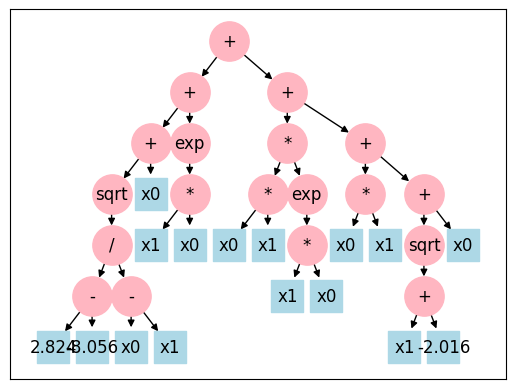

In [25]:
print(f"Variables: {VARIABLES}")
print(f"x_validation shape: {x_validation.shape}")
print(f"y_validation shape: {y_validation.shape}")

N = x_validation.shape[1]
print(f"Total number of samples = {N}")

print("\nTraining:\n")
TRAIN_SIZE = N // 10
print(f"TRAIN_SIZE = {TRAIN_SIZE}")

train_indexes = np.random.choice(N, size=TRAIN_SIZE, replace=False)

x_train = x_validation[:, train_indexes]
y_train = y_validation[train_indexes]

best_individual_training, best_fit_training, hall_of_fame_training = run_genetic_programming(
    x_train, y_train,
    population_size=300,
    generations=200,
    elite_size=2
)


expr_str_training = tree_to_string(best_individual_training)
print(f"\nBest expression found = {expr_str_training}, MSE = {best_fit_training}")

gx_best_individual_training = convert_to_gxgp_node(best_individual_training)
print("Final Expression Tree (GP on training set):")
draw(gx_best_individual_training)


## Test

Test:



C:\Users\utente\AppData\Local\Temp\ipykernel_12412\547468038.py:6: RuntimeWarning: overflow encountered in square
  mse = np.mean((y - y_pred)**2)


[Gen 0] Best MSE: 683.95123 => abs((8.188 * x0))
[Gen 1] Best MSE: 672.29683 => (x0 * (x1 * ((-2.169 * x1) + (9.865 - 1.792))))
[Gen 2] Best MSE: 672.29683 => (x0 * (x1 * ((-2.169 * x1) + (9.865 - 1.792))))
[Gen 3] Best MSE: 659.26738 => abs((x0 + (x1 * (0.299 + 8.490))))
[Gen 4] Best MSE: 647.40851 => abs((x0 + (x1 * (exp(x0) + (2.185 + 4.823)))))
[Gen 5] Best MSE: 630.87453 => ((((x0 - 0.403) * (1.571 * x1)) + abs((x0 + (x1 * (x0 + x0))))) + (2.185 + 4.823))
[Gen 6] Best MSE: 630.87453 => ((((x0 - 0.403) * (1.571 * x1)) + abs((x0 + (x1 * (x0 + x0))))) + (2.185 + 4.823))
[Gen 7] Best MSE: 523.38907 => ((x1 * (x1 + x0)) * exp(1.967))
[Gen 8] Best MSE: 491.43635 => ((((x0 - 0.403) * (9.723 * x1)) + abs((x0 + (x1 * (8.459 + x1))))) + abs((x0 + (x1 * ((x0 * x0) + (x1 - x0))))))
[Gen 9] Best MSE: 491.43635 => ((((x0 - 0.403) * (9.723 * x1)) + abs((x0 + (x1 * (8.459 + x1))))) + abs((x0 + (x1 * ((x0 * x0) + (x1 - x0))))))
[Gen 10] Best MSE: 491.43635 => ((((x0 - 0.403) * (9.723 * x1)) + abs(

C:\Users\utente\AppData\Local\Temp\ipykernel_12412\1136753074.py:63: RuntimeWarning: overflow encountered in mul (vectorized)
  return vfunc(arr1, arr2).astype(float)


[Gen 109] Best MSE: 338.29370 => ((abs(exp((x1 * x0))) + ((sqrt((4.399 + x1)) + abs(x0)) + cos((1.741 + (x0 + x1))))) + abs((((x1 - 0.403) - exp((x0 * x1))) * (x1 * x0))))
[Gen 110] Best MSE: 338.29370 => ((abs(exp((x1 * x0))) + ((sqrt((4.399 + x1)) + abs(x0)) + cos((1.741 + (x0 + x1))))) + abs((((x1 - 0.403) - exp((x0 * x1))) * (x1 * x0))))
[Gen 111] Best MSE: 338.29370 => ((abs(exp((x1 * x0))) + ((sqrt((4.399 + x1)) + abs(x0)) + cos((1.741 + (x0 + x1))))) + abs((((x1 - 0.403) - exp((x0 * x1))) * (x1 * x0))))
[Gen 112] Best MSE: 338.29370 => ((abs(exp((x1 * x0))) + ((sqrt((4.399 + x1)) + abs(x0)) + cos((1.741 + (x0 + x1))))) + abs((((x1 - 0.403) - exp((x0 * x1))) * (x1 * x0))))
[Gen 113] Best MSE: 330.41906 => ((abs(exp((x1 * x0))) + ((sqrt((-4.208 + -5.477)) + (x1 * x0)) + cos((x0 + (8.703 + x1))))) + abs((((x1 - 0.403) - exp((x1 * x0))) * (x1 * x0))))
[Gen 114] Best MSE: 330.41906 => ((abs(exp((x1 * x0))) + ((sqrt((-4.208 + -5.477)) + (x1 * x0)) + cos((x0 + (8.703 + x1))))) + abs(((

c:\Users\utente\università\computational intelligence\CI2024\Lib\site-packages\numpy\_core\_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


[Gen 172] Best MSE: 275.34649 => (((exp((x1 * x0)) * (x1 * x0)) + (exp((x1 * x0)) + log10((x0 / x0)))) + sqrt((log10((x1 * x0)) + ((-7.812 / 1.750) / (exp(-6.685) + (x0 - x1))))))
[Gen 173] Best MSE: 275.34649 => (((exp((x1 * x0)) * (x1 * x0)) + (exp((x1 * x0)) + log10((x0 / x0)))) + sqrt((log10((x1 * x0)) + ((-7.812 / 1.750) / (exp(-6.685) + (x0 - x1))))))
[Gen 174] Best MSE: 275.34649 => (((exp((x1 * x0)) * (x1 * x0)) + (exp((x1 * x0)) + log10((x0 / x0)))) + sqrt((log10((x1 * x0)) + ((-7.812 / 1.750) / (exp(-6.685) + (x0 - x1))))))
[Gen 175] Best MSE: 275.34649 => (((exp((x1 * x0)) * (x1 * x0)) + (exp((x1 * x0)) + log10((x0 / x0)))) + sqrt((log10((x1 * x0)) + ((-7.812 / 1.750) / (exp(-6.685) + (x0 - x1))))))
[Gen 176] Best MSE: 275.34649 => (((exp((x1 * x0)) * (x1 * x0)) + (exp((x1 * x0)) + log10((x0 / x0)))) + sqrt((log10((x1 * x0)) + ((-7.812 / 1.750) / (exp(-6.685) + (x0 - x1))))))
[Gen 177] Best MSE: 275.34649 => (((exp((x1 * x0)) * (x1 * x0)) + (exp((x1 * x0)) + log10((x0 / x0))

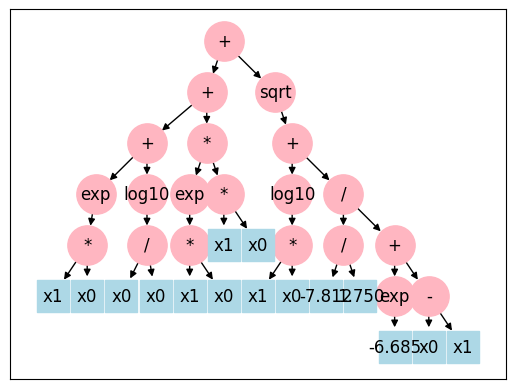

In [26]:
print("Test:\n")
best_individual, best_fit, hall_of_fame = run_genetic_programming(
    x_validation, y_validation,
    population_size=300,
    generations=200,
    elite_size=2
)

expr_str = tree_to_string(best_individual)
print(f"\nBest expression found = {expr_str}, MSE = {best_fit}")

gx_best_individual = convert_to_gxgp_node(best_individual)
print("Final Expression Tree (GP on test set):")
draw(gx_best_individual)
